# Lab3
Noam Yan

## Problem 1
1.A

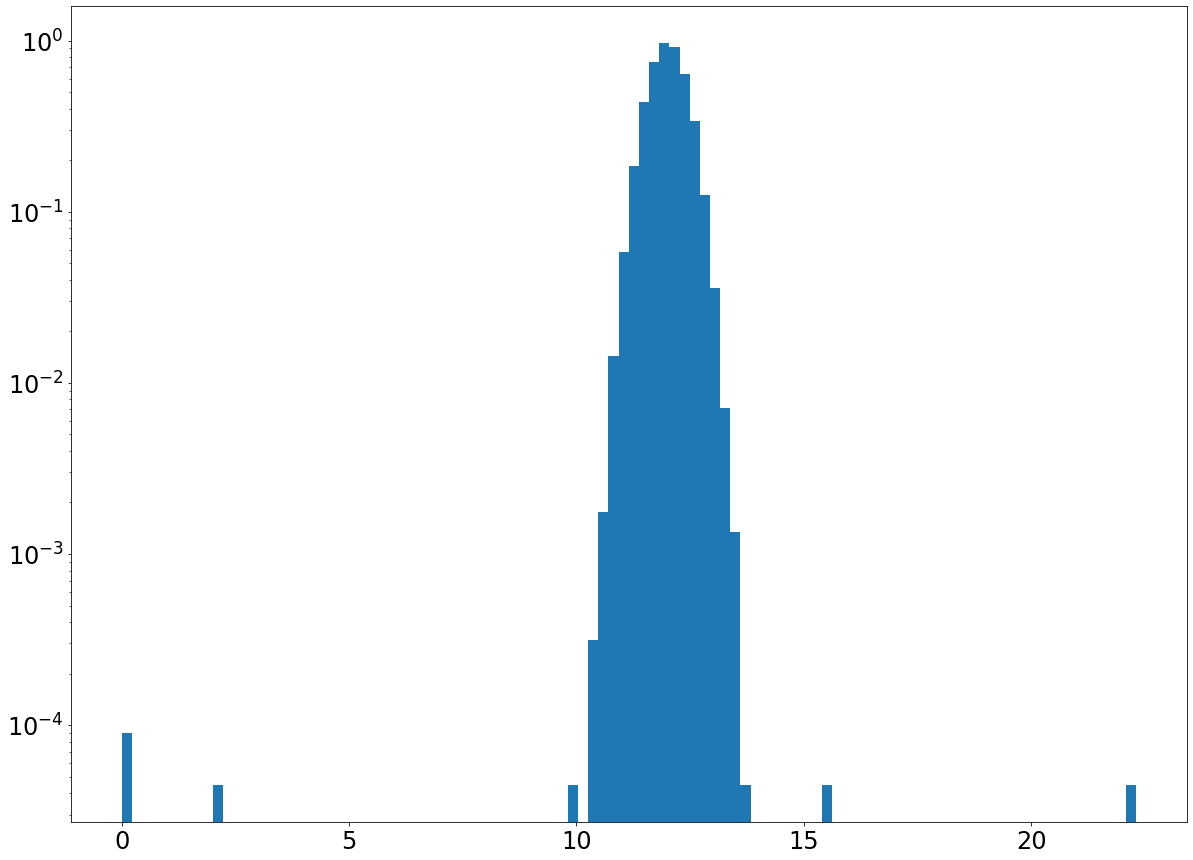

In [112]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)
norm_dist = stats.norm.rvs(loc = 12., scale = 0.4, size = 100000)
d = np.append(norm_dist, [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.show()

In [121]:
from scipy import stats as stats
# get the range of normal distribution
_,minmax,_,_,_,_ = stats.describe(norm_dist)
print(d.shape)

(100008,)


In [123]:
def detectOutliers(minmax,data):
    outliers = []
    for ele in data:
        if ele>= minmax[0] and ele<=minmax[1]:
            continue
        else: 
            outliers.append(ele)
    return outliers

def rejectOutliers(minmax,data):
    index = []
    for i,ele in enumerate(data):
        if ele>= minmax[0] and ele<=minmax[1]:
            continue
        else: 
            index.append(i)
    data = np.delete(d,index)
    return data

outliers = detectOutliers(minmax,d)
validValue = rejectOutliers(minmax,d)
print("We have %d outliers, which are %s"%(len(outliers),outliers))
print("and %d valid values"%len(validValue))

We have 7 outliers, which are [10.0, 10.3, 2.1, 0.0, 0.0, 15.6, 22.3]
and 100001 valid values


2. The statistical question is "What is the threshold that the valid value are in the range (12±threshold) and outliers are excluded?"<br>
3. setting up a range (12-threshold,12+threshold), if the elements in this range is also in normal distribution, then it is TruePositive, otherwise, FalsePositve; if the elements out of this range is also out of the nomal distribution, then it is TrueNegative, otherwise FalseNegative.

In [197]:
def eval(threshold,data,trueNeg,truePos):
    minmax = (12-threshold,12+threshold)
    predNeg = detectOutliers(minmax,data)
    predPos = rejectOutliers(minmax,data)
    
    N = len(predNeg)
    P = len(predPos)
    
    TP,FP,FN,TN = 0,0,0,0
    
    for neg in predNeg:
        if neg in trueNeg:
            TN+=1
    FN = N - TN
    
    for pos in predPos:
        if pos in truePos:
            TP+=1
    FP = P - TP
    return TP,FP,FN,TN

[Text(0.5, 0, 'threshold'), Text(0.5, 0, 'threshold')]

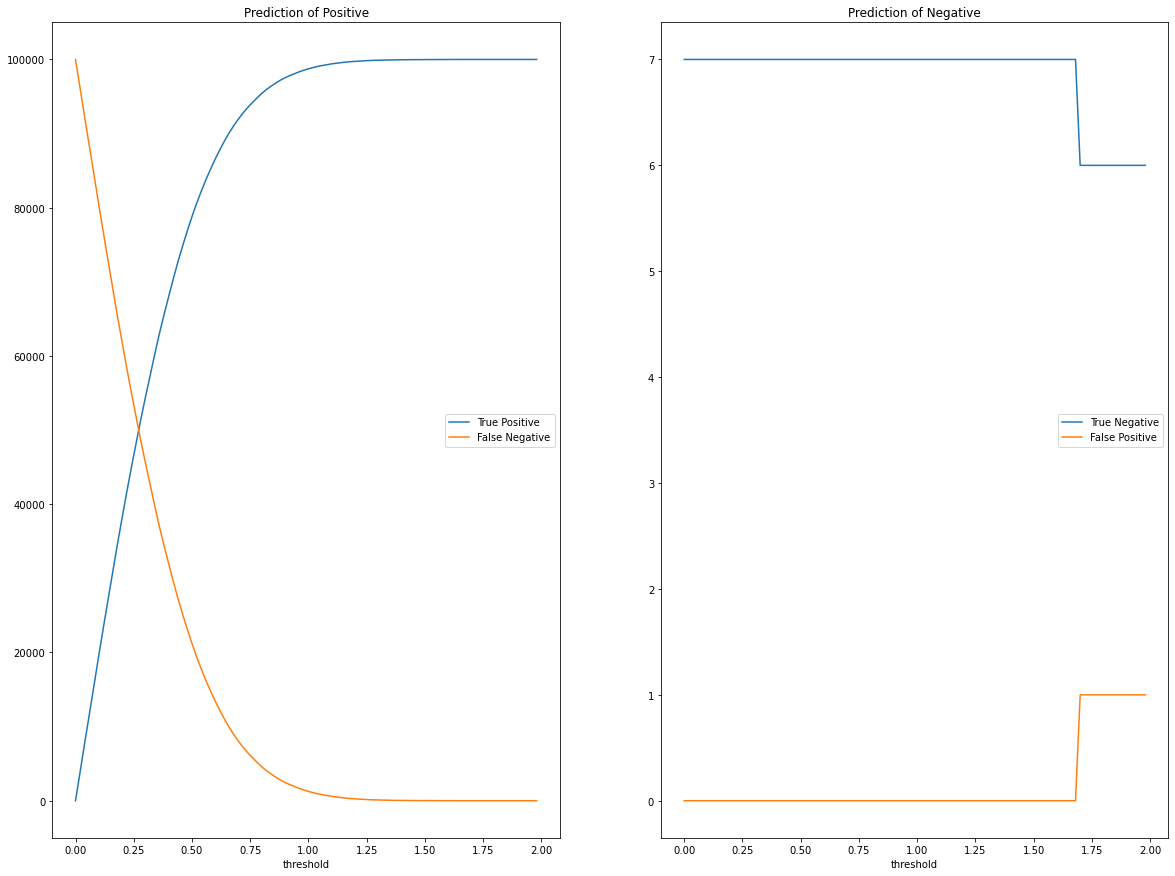

In [202]:
thresholds = np.arange(0,2,.02)
fig,ax=plt.subplots(1, 2)
posList = []
negList = []
for threshold in tqdm(thresholds):
    TP,FP,FN,TN = eval(threshold,d,outliers,validValue)
    posList.append([TP,FP])
    negList.append([TN,FN])

posList = np.transpose(posList,(1,0))
negList = np.transpose(negList,(1,0))

ax[0].plot(thresholds,posList[0],label="True Positive")
ax[0].plot(thresholds,negList[1],label="False Negative")
ax[1].plot(thresholds,negList[0],label="True Negative")
ax[1].plot(thresholds,posList[1],label="False Positive")

ax[0].legend()
ax[1].legend()
ax[0].set_title("Prediction of Positive")
ax[1].set_title("Prediction of Negative")
plt.setp(ax,xlabel="threshold")

B) As threshold increses, FN decreases, which means less positive samples are dropped.When the threshold is greater than 1.5, almost every sample is seen as positive so no omission occurs, so it is predictable.

C) Yes, when threshold is greater than , bad data becomes getting in. That is also why we need precission. This situation can be avoid by choosing a small threshold. <br><br>
This is an interesting tradeoff, if you set the threshold too large, you will get a high recall (TP/ (TP+FN)) and omit few positive samples. Especially, if you set threshold to infinity, everything will be seen as positive and you recall=100%, but the precission (TP/ (TP+FP)) is very low. On the other hand, if you set the threshold too small, you omit a lot of true positive sample, the precision will be very high, but recall is low.